<h1><center>Data Augmentation using GANs </center></h1>

In this notebook we will introduce the Pix2Pix and CycleGAN training process on data created from carla simulator. In this repository you will find a smaller dataset for demonstration purposes. A larger dataset can be find on <a href="https://www.kaggle.com/datasets/buraka61/carla-simulator-weather-data-default-to-rainy">Kaggle.com</a>.

In [1]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
import os
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.layers import BatchNormalization
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

c:\Users\burak.altin\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\burak.altin\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.14.0 and is not supported. 
Some things might work, some things might not.
If you we

In [2]:
class define_discriminator():
      def pix2pix(image_shape):   
          # weight initialization
            init = RandomNormal(stddev=0.02)
            # source image input
            in_src_image = Input(shape=image_shape)
            # target image input
            in_target_image = Input(shape=image_shape)
            # concatenate images channel-wise
            merged = Concatenate()([in_src_image, in_target_image])
            # C64
            d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
            d = LeakyReLU(alpha=0.2)(d)
            # C128
            d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
            d = BatchNormalization()(d)
            d = LeakyReLU(alpha=0.2)(d)
            # C256
            d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
            d = BatchNormalization()(d)
            d = LeakyReLU(alpha=0.2)(d)
            # C512
            d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
            d = BatchNormalization()(d)
            d = LeakyReLU(alpha=0.2)(d)
            # second last output layer
            d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
            d = BatchNormalization()(d)
            d = LeakyReLU(alpha=0.2)(d)
            # patch output
            d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
            patch_out = Activation('sigmoid')(d)
            # define model
            model = Model([in_src_image, in_target_image], patch_out)
            # compile model
            opt = Adam(learning_rate=0.0002, beta_1=0.5)
            model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
            return model
      
      def cycle_gan(image_shape):
          # weight initialization
            init = RandomNormal(stddev=0.02)
            # source image input
            in_image = Input(shape=image_shape)
            # C64
            d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
            d = LeakyReLU(alpha=0.2)(d)
            # C128
            d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
            d = InstanceNormalization(axis=-1)(d)
            d = LeakyReLU(alpha=0.2)(d)
            # C256
            d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
            d = InstanceNormalization(axis=-1)(d)
            d = LeakyReLU(alpha=0.2)(d)
            # C512
            d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
            d = InstanceNormalization(axis=-1)(d)
            d = LeakyReLU(alpha=0.2)(d)
            # second last output layer
            d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
            d = InstanceNormalization(axis=-1)(d)
            d = LeakyReLU(alpha=0.2)(d)
            # patch output
            patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
            # define model
            model = Model(in_image, patch_out)
            # compile model
            model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])
            return model
          
            
            
     

In [20]:
discriminator1 = define_discriminator.pix2pix(image_shape=[200,200,200])
discriminator2 = define_discriminator.cycle_gan(image_shape=[200,200,200])

Loaded:  (60, 256, 256, 3) (60, 256, 256, 3)


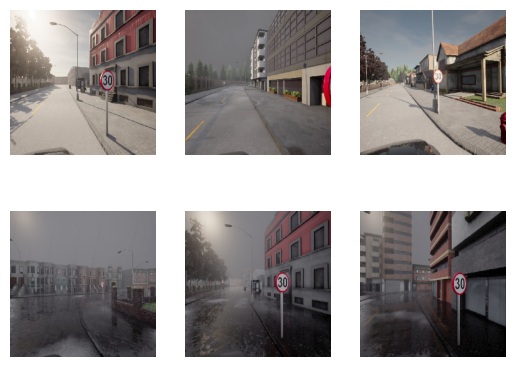

In [6]:
# load and plot the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the face dataset
data = load("default2rainy_small_256.npz")
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(dataB[i].astype('uint8'))
pyplot.show()

1. Pix2Pix Network

1.1 Pix2Pix Discriminator

In [7]:
def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_src_image = Input(shape=image_shape)
    # target image input
    in_target_image = Input(shape=image_shape)
    # concatenate images channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

1.2 Pix2Pix Encoder Block

In [2]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same',
    kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

1.3 Pix2Pix Decoder Block

In [ ]:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same',
    kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

1.4 Pix2Pix Generator

In [3]:
def define_generator(image_shape=(256,256,3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    # decoder model
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    # output
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model

1.5 Results Sample

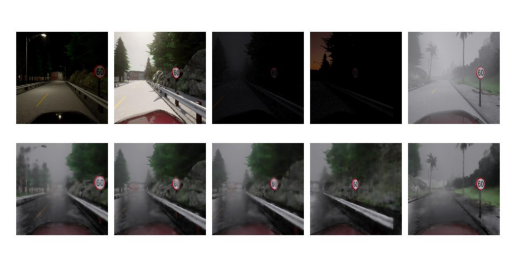

In [4]:


# Open the image using Pillow
image_path = r"C:\Users\Administrador\Desktop\Mestrado\3. Semester\Modellierungsseminar\output_grid.jpg"
image = Image.open(image_path)

# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()


### Cycle Gan

#### 1. Discriminator


In [ ]:
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

#### 2. Generator

In [ ]:
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

In [ ]:
# define the standalone generator model
def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model


### Composit Model

In [ ]:
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    g_model_1.trainable = True
    d_model.trainable = False
    g_model_2.trainable = False
    input_gen = Input(shape=image_shape)
    gen1_out = g_model_1(input_gen)
    output_d = d_model(gen1_out)
    input_id = Input(shape = image_shape)
    output_id = g_model_1(input_id)
    output_f = g_model_2(gen1_out)
    gen2_out = g_model_2(input_id)
    output_b = g_model_1(gen2_out)
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
    return model

### Fake/True Generator

In [ ]:
def generate_real_samples(dataset, n_samples, patch_shape):
	ix = randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y